<a href="https://colab.research.google.com/github/fjavier141/proyecto-final-magister-ds/blob/main/exploracion_inicial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from ydata_profiling import ProfileReport

sns.set(style="whitegrid")

# =========================================
# 1) Conexión y extracción
# =========================================

ROOT = Path().resolve().parent
OUT_DIR = Path("./data/output")
PLOTS_DIR = OUT_DIR / "plots"
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
load_dotenv(dotenv_path=ROOT / ".env")

# Parámetros de conexión (ajusta a tu entorno)
USER = os.getenv("POSTGRES_USER")
PASSWORD = os.getenv("POSTGRES_PASSWORD")
HOST = os.getenv("POSTGRES_HOST")
PORT = os.getenv("POSTGRES_PORT", "5432")
DB = os.getenv("POSTGRES_DB")

# Crea el motor SQLAlchemy
engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# Test de conexión
try:
    with engine.connect() as conn:
        version = conn.execute(text("SELECT version();"))
        print("Conectado a:", list(version)[0][0])
except Exception as e:
    print("Error al conectar:", e)


Conectado a: PostgreSQL 15.13 (Debian 15.13-1.pgdg120+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit


In [2]:
#Extracción data dimensional
with engine.connect() as conn:
    clientes = pd.read_sql(text("SELECT id_cliente, id_barrio, id_comuna, segmento, canal, descr_flag_patente FROM stg.base_clientes;"), conn)

with engine.connect() as conn:
    barrios = pd.read_sql(text("SELECT id_barrio, indice_gse, n_habitantes, n_ptos_interes, superficie_km2, densidad_hab FROM stg.info_distritos;"), conn)    

with engine.connect() as conn:
    macro_vars = pd.read_sql(text("SELECT id_periodo, uf, dolar, ipc, imacec, tpm, tasa_desempleo FROM stg.datos_macro;"), conn) 
    


In [3]:
#Extracción venta cervezas

with engine.connect() as conn:
    ventas_cervezas = pd.read_sql(text("SELECT id_categoria, id_cliente, id_periodo, tipo_mix, id_sku_venta, liq_um FROM stg.venta_historica WHERE id_categoria=1;"), conn)

#Extracción venta analcohólicos

with engine.connect() as conn:
    ventas_analcoholicos = pd.read_sql(text("SELECT id_categoria, id_cliente, id_periodo, tipo_mix, id_sku_venta, liq_um FROM stg.venta_historica WHERE id_categoria=3;"), conn)


In [4]:
# Revisión general del dataset

excel_path = OUT_DIR / "eda_descriptivos.xlsx"
writer = pd.ExcelWriter(excel_path, engine="xlsxwriter")

def revision_gral_dataset(dfx, dataset_name=None, writer=None):
    df = dfx.copy()

    print("Dimensiones:", df.shape)
    print("Tipos de variables:")
    print(df.dtypes)

    print("Diccionario de datos:")
    for col in df.columns:
        nunique = df[col].nunique()
        null_pct = df[col].isna().mean() * 100
        print(f" - {col}: tipo={df[col].dtype}, únicos={nunique}, nulos={null_pct:.2f}%")

    print("Unidades y dominios esperados:")
    if "liq_um" in df.columns:
        print(" - liq_um: volumen en hectolitros (HL), valores válidos >= 0")
        print("   Valores negativos:", (df["liq_um"] < 0).sum())
        print("   Máximo:", df["liq_um"].max(), "mínimo:", df["liq_um"].min())

    print("Reglas de negocio y consistencia de llaves:")
    if set(["id_cliente", "id_periodo", "id_sku_venta"]).issubset(df.columns):
        dups = df.duplicated(subset=["id_cliente", "id_periodo", "id_sku_venta"]).sum()
        print(f"Duplicados por (id_cliente, id_periodo, id_sku_venta): {dups}")
    else:
        print("Sin llaves obvias detectadas.")

    print("Valores faltantes:")
    top_nulos = df.isna().mean().sort_values(ascending=False).head(10)
    print(top_nulos)

    # ===== NUEVO: guardado a Excel (si se provee) =====
    if writer is not None and dataset_name is not None:
        # esquema básico: dtype, únicos, % nulos
        schema_rows = []
        for col in df.columns:
            schema_rows.append({
                "col": col,
                "dtype": str(df[col].dtype),
                "nunique": df[col].nunique(dropna=True),
                "null_pct": round(df[col].isna().mean() * 100, 2)
            })
        schema_df = pd.DataFrame(schema_rows).sort_values("col")
        schema_df.to_excel(writer, sheet_name=f"{dataset_name[:25]}_schema", index=False)

        top_nulos.rename("null_pct").to_frame().to_excel(
            writer, sheet_name=f"{dataset_name[:25]}_nulos"
        )

print('*** Revisión general dataset de clientes ***')
revision_gral_dataset(clientes, dataset_name="clientes", writer=writer)
print('*** Revisión general dataset de barrios ***')
revision_gral_dataset(barrios, dataset_name="barrios", writer=writer)
print('*** Revisión general dataset variables macroeconómicas ***')
revision_gral_dataset(macro_vars, dataset_name="macro_vars", writer=writer)
print('*** Revisión general dataset de ventas cervezas ***')
revision_gral_dataset(ventas_cervezas, dataset_name="ventas_cervezas", writer=writer)
print('*** Revisión general dataset de ventas analcohólicos ***')
revision_gral_dataset(ventas_analcoholicos, dataset_name="ventas_analcoholicos", writer=writer)


*** Revisión general dataset de clientes ***
Dimensiones: (727519, 6)
Tipos de variables:
id_cliente              int64
id_barrio             float64
id_comuna             float64
segmento               object
canal                  object
descr_flag_patente     object
dtype: object
Diccionario de datos:
 - id_cliente: tipo=int64, únicos=727519, nulos=0.00%
 - id_barrio: tipo=float64, únicos=2090, nulos=66.17%
 - id_comuna: tipo=float64, únicos=334, nulos=0.00%
 - segmento: tipo=object, únicos=26, nulos=0.00%
 - canal: tipo=object, únicos=3, nulos=0.00%
 - descr_flag_patente: tipo=object, únicos=4, nulos=0.00%
Unidades y dominios esperados:
Reglas de negocio y consistencia de llaves:
Sin llaves obvias detectadas.
Valores faltantes:
id_barrio             0.661690
id_comuna             0.000007
id_cliente            0.000000
segmento              0.000000
canal                 0.000000
descr_flag_patente    0.000000
dtype: float64
*** Revisión general dataset de barrios ***
Dimensiones: 

Estadísticos descriptivos principales:
               count           mean            std       min       25%  \
id_cliente  727519.0  363760.000000  210016.789583       1.0  181880.5   
id_barrio   246127.0  937675.262080  394924.601593  110110.0  610117.0   
id_comuna   727514.0    8996.264472    3991.757922       0.0    5603.0   

                 50%        75%        max          skew  kurtosis  
id_cliente  363760.0   545639.5   727519.0 -1.166962e-16 -1.200000  
id_barrio   920117.0  1311925.0  1510511.0 -4.006520e-01 -1.167931  
id_comuna     9101.0    13114.0    96285.0 -2.696345e-01 -0.503321  
id_cliente: outliers 0 (0.00%)  |  IQR=[181880.500,545639.500]  thr=[-363758.000,1091278.000]
id_barrio: outliers 0 (0.00%)  |  IQR=[610117.000,1311925.000]  thr=[-442595.000,2364637.000]
id_comuna: outliers 2 (0.00%)  |  IQR=[5603.000,13114.000]  thr=[-5663.500,24380.500]
Estadísticos descriptivos principales:
                 count           mean            std            min  \
id_b

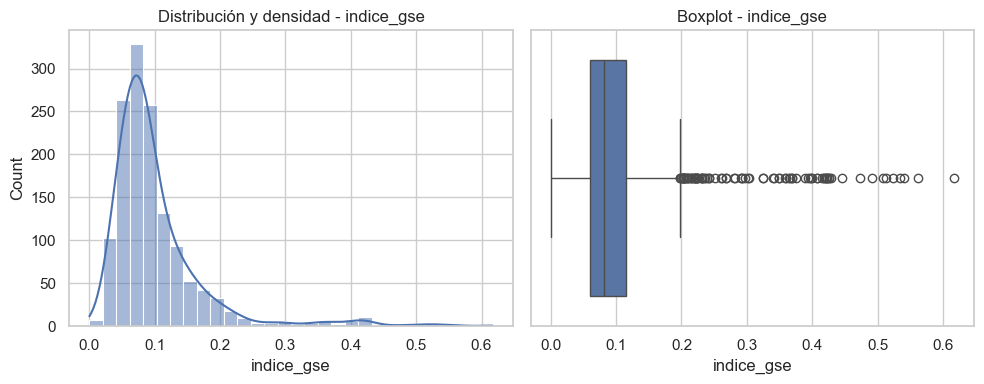

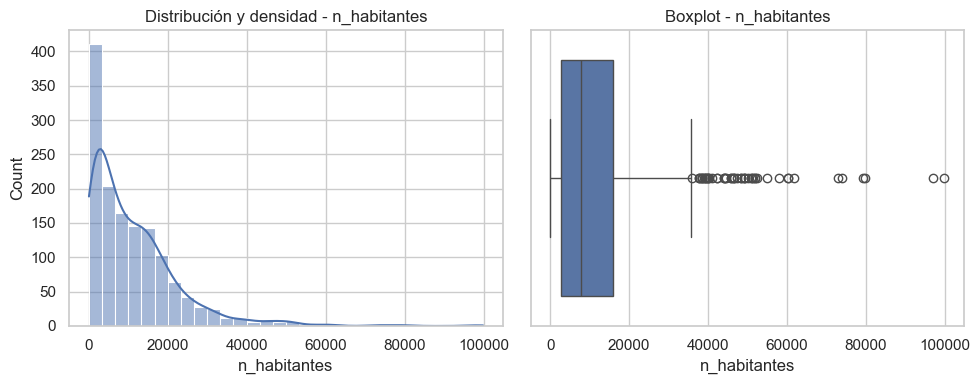

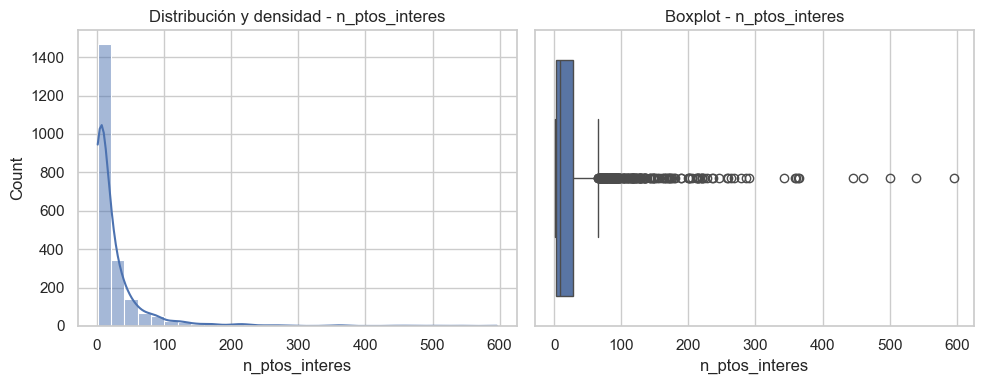

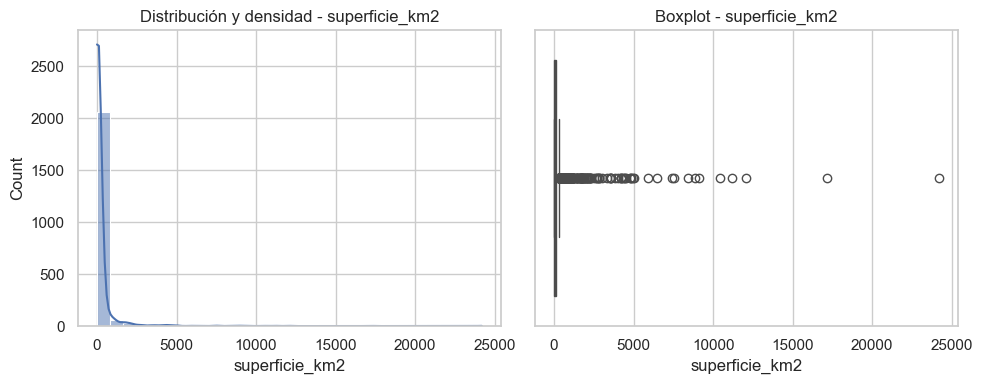

Estadísticos descriptivos principales:
                count           mean          std        min          25%  \
id_periodo       85.0  202185.364706   207.199113  201810.00  202007.0000   
uf               85.0   32858.885294  4236.356143   27432.10   28696.4200   
dolar            85.0     832.665882    97.596677     649.92     754.4500   
ipc              84.0       0.439286     0.453904      -0.50       0.1000   
imacec           83.0       2.166265     6.564172     -15.30      -0.7000   
tpm              85.0       4.882353     3.623376       0.50       1.7500   
tasa_desempleo   82.0       8.537439     1.408462       6.70       7.7625   

                       50%        75%        max      skew  kurtosis  
id_periodo      202204.000  202401.00  202510.00 -0.017654 -1.162427  
uf               32176.490   36789.36   39597.67  0.164500 -1.602820  
dolar              826.260     919.97     992.12 -0.030332 -1.187594  
ipc                  0.400       0.70       1.90  0.656254  

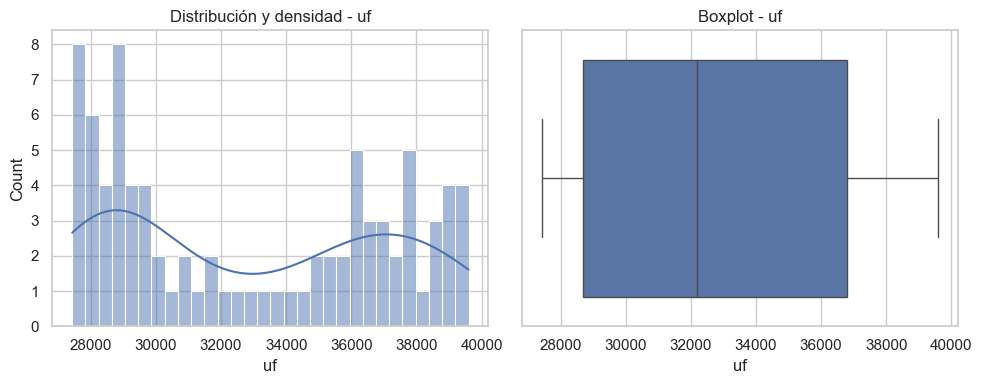

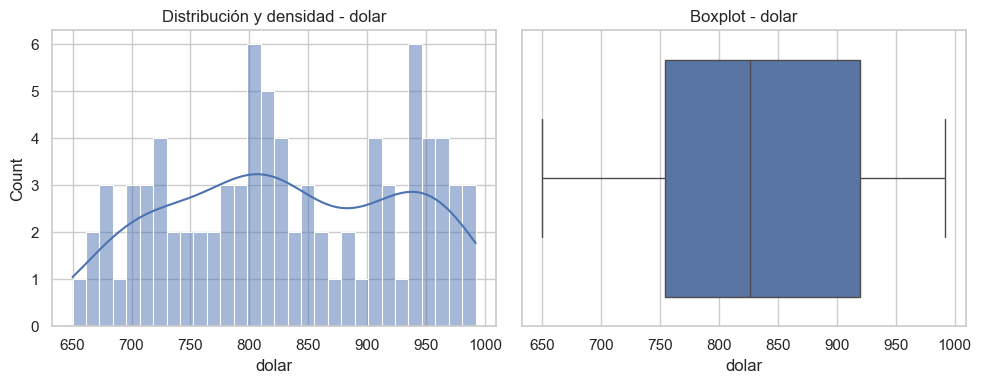

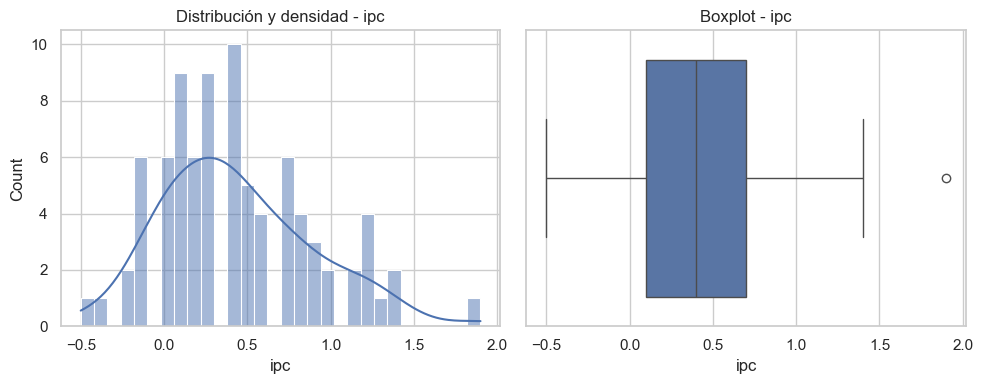

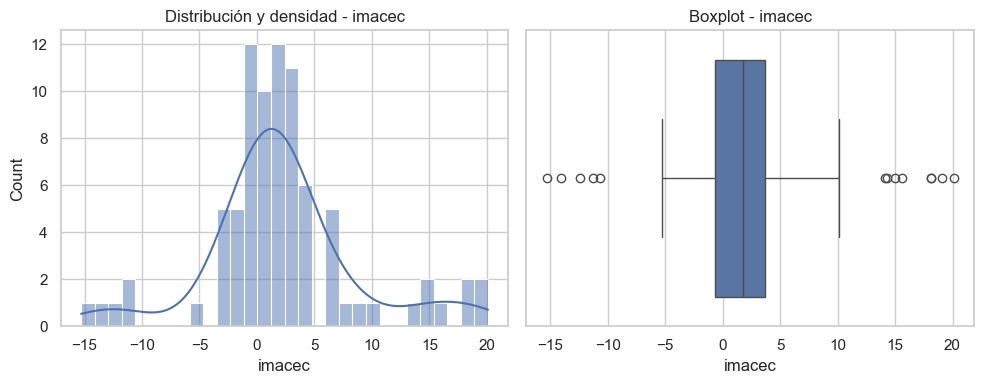

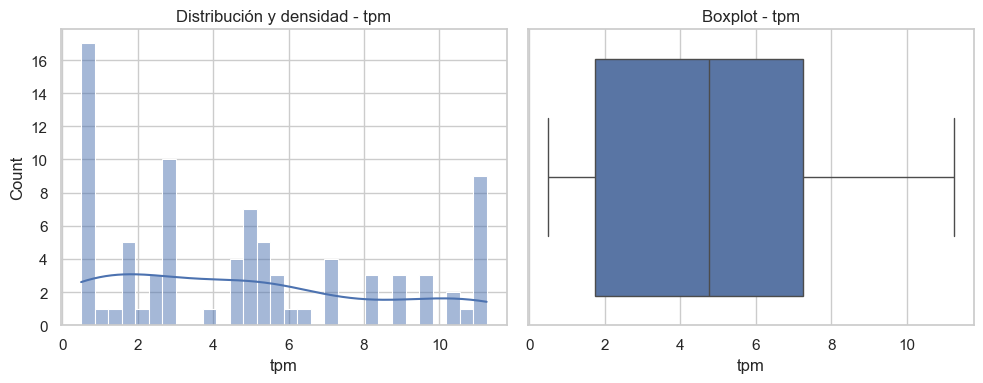

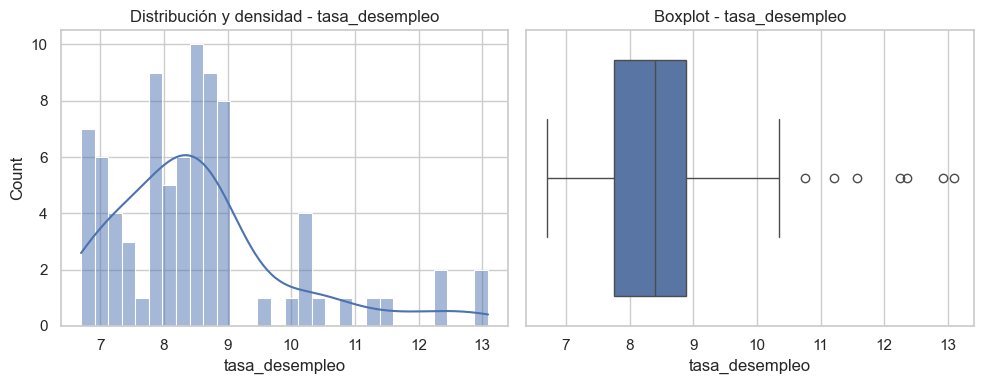

Estadísticos descriptivos principales:
                   count           mean            std        min         25%  \
id_categoria  28327324.0       1.000000       0.000000       1.00       1.000   
id_cliente    28327324.0  372401.024348  203824.560120      13.00  190023.000   
id_periodo    28327324.0  202190.022621     199.645985  201809.00  202010.000   
id_sku_venta  28327324.0  428579.433965  104985.770946     515.00  450325.000   
liq_um        28327324.0       0.930813       7.372279     -89.46       0.084   

                    50%         75%           max       skew      kurtosis  
id_categoria       1.00       1.000       1.00000   0.000000      0.000000  
id_cliente    374107.00  556663.000  727517.00000  -0.072203     -1.200075  
id_periodo    202206.00  202401.000  202508.00000  -0.119113     -1.054474  
id_sku_venta  450604.00  450749.000  604926.00000  -3.593588     12.112201  
liq_um             0.21       0.588    3096.65328  78.478718  12213.227830  
id_categoria

In [5]:
# Análisis univariado
def analisis_univariado(dfx, dataset_name=None, save_png=False, bins=30, max_vars=50, writer=None, save_outlier_rows=False):
    df = dfx.copy()
    print("Estadísticos descriptivos principales:")
    desc = df.describe(percentiles=[0.25, 0.5, 0.75]).T
    desc["skew"] = df.skew(numeric_only=True)
    desc["kurtosis"] = df.kurtosis(numeric_only=True)
    print(desc)

    # ===== Guardar descriptivo a Excel (si se provee) =====
    if writer is not None and dataset_name is not None:
        desc.to_excel(writer, sheet_name=f"{dataset_name[:28]}_desc")

    # Detección de colas pesadas y outliers (método IQR)
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    out_summary_rows = []
    out_rows_long = []   # opcional (muestra filas outlier)

    for col in num_cols:
        s = df[col].dropna()
        n = len(s)
        if n == 0:
            continue

        Q1, Q3 = np.percentile(s, [25, 75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        mask = (s < lower) | (s > upper)
        n_out = int(mask.sum())
        pct_out = (n_out / n) * 100 if n > 0 else 0.0

        out_summary_rows.append({
            "col": col,
            "count": n,
            "outliers": n_out,
            "pct_outliers": round(pct_out, 2),
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "lower": lower,
            "upper": upper,
            "min": float(s.min()),
            "max": float(s.max()),
        })

        print(f"{col}: outliers {n_out} ({pct_out:.2f}%)  |  IQR=[{Q1:.3f},{Q3:.3f}]  thr=[{lower:.3f},{upper:.3f}]")

        if save_outlier_rows and n_out > 0:
            # guardamos una muestra acotada de filas outlier (hasta 200 total por dataset)
            s_out = s[mask]
            # tomamos una muestra por columna (máx 200/num_cols para no reventar)
            k = max(1, 200 // max(1, len(num_cols)))
            s_out_sample = s_out.head(k)
            out_rows_long.append(
                pd.DataFrame({
                    "col": col,
                    "index": s_out_sample.index,
                    "value": s_out_sample.values
                })
            )

    # ===== Guardar resumen de outliers (y sample de filas) a Excel =====
    if writer is not None and dataset_name is not None and len(out_summary_rows) > 0:
        out_summary_df = pd.DataFrame(out_summary_rows).sort_values("pct_outliers", ascending=False)
        out_summary_df.to_excel(writer, sheet_name=f"{dataset_name[:25]}_outliers", index=False)

        if save_outlier_rows and len(out_rows_long) > 0:
            out_rows_df = pd.concat(out_rows_long, ignore_index=True)
            # Por si el index original es jerárquico o no numérico, lo convertimos a str
            out_rows_df["index"] = out_rows_df["index"].astype(str)
            out_rows_df.to_excel(writer, sheet_name=f"{dataset_name[:23]}_out_rows", index=False)

    if len(num_cols) > max_vars:
        num_cols = num_cols[:max_vars]  # por si hay demasiadas columnas

    out_dir = None
    if save_png and dataset_name is not None:
        out_dir = PLOTS_DIR / dataset_name
        out_dir.mkdir(parents=True, exist_ok=True)

    plot_cols = [
        c for c in num_cols
        if not any(k in c.lower() for k in ["id", "codigo", "sku", "liq_um"])
    ]
    if len(plot_cols) > max_vars:
        plot_cols = plot_cols[:max_vars]

    for col in plot_cols:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=bins)
        plt.title(f"Distribución y densidad - {col}")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot - {col}")
        plt.tight_layout()

        if out_dir is not None:
            safe_col = str(col).replace("/", "_").replace("\\", "_")
            plt.savefig(out_dir / f"{dataset_name}__{safe_col}.png", dpi=150)

        plt.show()
        plt.close()


analisis_univariado(clientes, dataset_name="clientes", save_png=True, writer=writer, save_outlier_rows=True)
analisis_univariado(barrios, dataset_name="barrios", save_png=True, writer=writer, save_outlier_rows=True)
analisis_univariado(macro_vars, dataset_name="macro_vars", save_png=True, writer=writer, save_outlier_rows=True)
analisis_univariado(ventas_cervezas, dataset_name="ventas_cervezas", save_png=True, writer=writer, save_outlier_rows=True)
analisis_univariado(ventas_analcoholicos, dataset_name="ventas_analcoholicos", save_png=True, writer=writer, save_outlier_rows=True)

writer.close()
print(f"Excel con descriptivos + outliers: {excel_path}")
print(f"PNGs: {PLOTS_DIR} (subcarpetas por dataset)")

In [ ]:
def get_profile_report(df, dataset_name):
    profile = ProfileReport(df, title=f"EDA {dataset_name}", explorative=True)
    profile.to_file(f"./data/output/eda_{dataset_name}.html")

get_profile_report(clientes, "clientes")
get_profile_report(barrios, "barrios")
get_profile_report(macro_vars, "macro_vars")
get_profile_report(ventas_cervezas, "ventas_cervezas")
get_profile_report(ventas_analcoholicos, "ventas_analcoholicos")




Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
df_full_cervezas = ventas_cervezas.merge(clientes, on=["id_cliente"],
                                                 how="left").merge(barrios, on=["id_barrio"],
                                                 how="left").merge(macro_vars, on=["id_periodo"], how="left")
df_full_analcoholicos = ventas_analcoholicos.merge(clientes, on=["id_cliente"],
                                                 how="left").merge(barrios, on=["id_barrio"],
                                                 how="left").merge(macro_vars, on=["id_periodo"], how="left")

get_profile_report(df_full_cervezas, "df_full_cervezas")
get_profile_report(df_full_analcoholicos, "df_full_analcoholicos")

In [ ]:
# Agregando volumenes por mes
ventas_cervezas_mensual = (
    ventas_cervezas.groupby(["id_cliente", "id_periodo"], as_index=False)
    .agg({"liq_um": "sum"})
)

ventas_analcoholicos_mensual = (
    ventas_analcoholicos.groupby(["id_cliente", "id_periodo"], as_index=False)
    .agg({"liq_um": "sum"})
)

df_full_cervezas_mensual = ventas_cervezas_mensual.merge(clientes, on=["id_cliente"],
                                                 how="left").merge(barrios, on=["id_barrio"],
                                                 how="left").merge(macro_vars, on=["id_periodo"], how="left")
df_full_analcoholicos_mensual = ventas_analcoholicos_mensual.merge(clientes, on=["id_cliente"],
                                                 how="left").merge(barrios, on=["id_barrio"],
                                                 how="left").merge(macro_vars, on=["id_periodo"], how="left")

get_profile_report(df_full_cervezas_mensual, "df_full_cervezas_mensual")
get_profile_report(df_full_analcoholicos_mensual, "df_full_analcoholicos_mensual")
